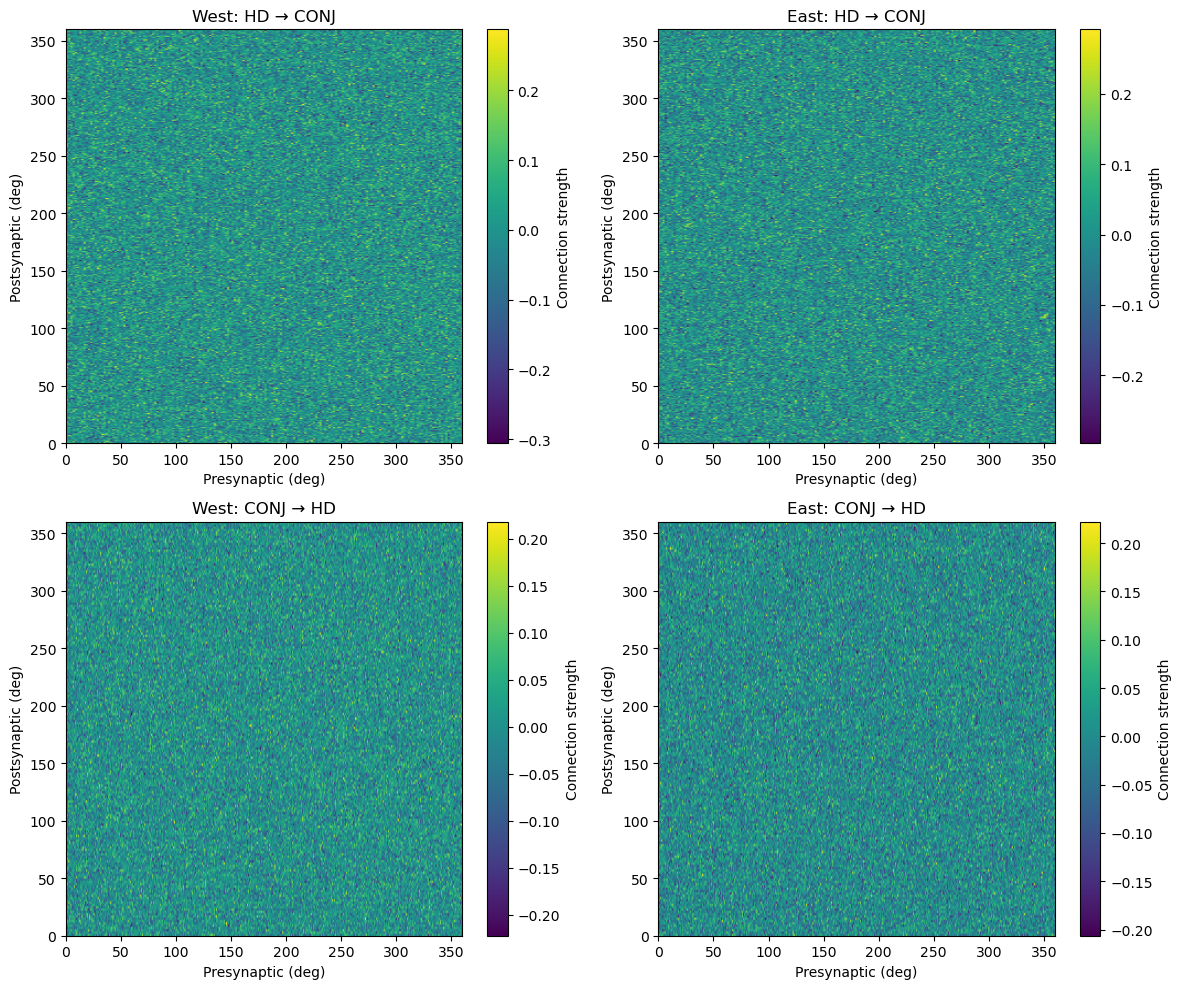

In [12]:
import numpy as np
import matplotlib.pyplot as plt

def angular_diff(x, y):
    diff = np.abs(x - y)
    return np.minimum(diff, 360 - diff)

def update_hd_cells(u_prev, r_conj, weights_conj_to_hd, r_adn, w4, γ_hd, τ_hd):
    decay = -u_prev
    inhibition = -γ_hd * np.sum(r_conj)
    conj_input = weights_conj_to_hd @ r_conj
    adn_input = w4 @ r_adn
    return (decay + inhibition + conj_input + adn_input) / τ_hd

def update_adn_cells(u_prev, r_adn, r_hd, w6, w5, γ_adn, pi_input, τ_adn):
    decay = -u_prev
    inhibition = -γ_adn * np.sum(r_adn)
    recurrent_input = w6 @ r_adn
    hd_input = w5 @ r_hd
    return (decay + inhibition + recurrent_input + hd_input + pi_input) / τ_adn

def hebbian_update(w, pre, post, lr=0.005):
    dw = lr * np.outer(post, pre)
    w_new = w + dw
    return w_new / np.linalg.norm(w_new, axis=1, keepdims=True)

def add_pi_noise(x_est, Δhd, xi, eta):
    noise = np.random.normal(loc=xi * Δhd, scale=eta * abs(Δhd))
    return (x_est + Δhd + noise) % 360

def get_vis_input(x_true, visual_shift, params):
    x = np.linspace(0, 360, params['N_vis'], endpoint=False)
    return params['VIS_strength'] * np.exp(-angular_diff(x, (x_true + visual_shift) % 360)**2 / (2 * params['VIS_width']**2))

def simulate_compartment(visual_shift, duration, params):
    N_hd, N_conj, N_adn = params['N_hd'], params['N_conj'], params['N_adn']
    u_hd, u_conj, u_adn = np.zeros(N_hd), np.zeros(N_conj), np.zeros(N_adn)
    weights_hd_conj = np.random.normal(0, 0.1, (N_conj, N_hd))
    weights_conj_hd = np.random.normal(0, 0.1, (N_hd, N_conj))
    w4 = np.exp(-angular_diff(np.linspace(0, 360, N_hd, endpoint=False)[:, None],
                              np.linspace(0, 360, N_adn, endpoint=False)[None, :])**2 / (2 * params['σ4']**2))
    w5 = np.exp(-angular_diff(np.linspace(0, 360, N_adn, endpoint=False)[:, None],
                              np.linspace(0, 360, N_hd, endpoint=False)[None, :])**2 / (2 * params['σ5']**2))
    w6 = np.exp(-angular_diff(np.linspace(0, 360, N_adn, endpoint=False)[:, None],
                              np.linspace(0, 360, N_adn, endpoint=False)[None, :])**2 / (2 * params['σ6']**2))
    x_true = 0
    x_est = 0

    for t in np.arange(0, duration, params['dt']):
        Δhd = np.random.normal(0, params['angular_velocity'] * params['dt'])
        x_true = (x_true + Δhd) % 360
        x_est = add_pi_noise(x_est, Δhd, params['pi_xi'], params['pi_eta'])

        vis_input = get_vis_input(x_true, visual_shift, params)
        pi_input = params['PI_strength'] * np.exp(-angular_diff(np.linspace(0, 360, N_adn, endpoint=False), x_est)**2 / (2 * params['PI_width']**2))

        r_hd = np.maximum(0, np.tanh(u_hd))
        r_conj = np.maximum(0, np.tanh(u_conj))
        r_adn = np.maximum(0, np.tanh(u_adn))

        du_adn = update_adn_cells(u_adn, r_adn, r_hd, w6, w5, params['γ_adn'], pi_input, params['τ_adn'])
        u_adn += du_adn * params['dt']

        du_conj = (-u_conj - params['γ_conj'] * np.sum(r_conj) + 
                   (1/N_hd) * weights_hd_conj @ r_hd + 
                   (1/params['N_vis']) * params['w3'] @ vis_input) / params['τ_conj']
        u_conj += du_conj * params['dt']

        du_hd = update_hd_cells(u_hd, r_conj, weights_conj_hd, r_adn, w4, params['γ_hd'], params['τ_hd'])
        u_hd += du_hd * params['dt']

        weights_hd_conj = hebbian_update(weights_hd_conj, r_hd, r_conj, params['lr'])
        weights_conj_hd = hebbian_update(weights_conj_hd, r_conj, r_hd, params['lr'])

    return weights_hd_conj, weights_conj_hd

def plot_weight_matrix(weights, title):
    plt.imshow(weights, cmap='viridis', aspect='auto', extent=[0, 360, 0, 360], origin='lower')
    plt.xlabel('Presynaptic (deg)')
    plt.ylabel('Postsynaptic (deg)')
    plt.title(title)
    plt.colorbar(label='Connection strength')

params = {
    'dt': 0.0001,
    'τ_hd': 0.001,
    'τ_conj': 0.001,
    'τ_adn': 0.001,
    'γ_hd': 20,
    'γ_conj': 7,
    'γ_adn': 5,
    'N_hd': 180,
    'N_conj': 360,
    'N_adn': 180,
    'N_vis': 180,
    'w3': np.exp(-angular_diff(np.linspace(0,360,360,endpoint=False)[:,None],
                               np.linspace(0,360,180,endpoint=False)[None,:])**2 / (2 * 20**2)),
    'lr': 0.005,
    'pi_xi': 0.005,
    'pi_eta': 0.005,
    'VIS_strength': 4,
    'VIS_width': 20,
    'PI_strength': 4,
    'PI_width': 10,
    'angular_velocity': 60,
    'σ4': 10,
    'σ5': 10,
    'σ6': 10
}

weights_west_hd_conj, weights_west_conj_hd = simulate_compartment(visual_shift=0, duration=60, params=params)

plt.figure(figsize=(12, 10))
plt.subplot(221)
plot_weight_matrix(weights_west_hd_conj, 'West: HD → CONJ')
plt.subplot(222)
plot_weight_matrix(weights_west_conj_hd, 'West: CONJ → HD')
plt.tight_layout()
plt.show()
